# VCGC: Vertex Coloring with Grover's Circuit 
Rudimentary Curcuit To Run Grover's Search Algorithm for a vertex coloring instance on the AER simulator and IBM's Quantum Computer. 

1. Prepare the circuit and add the uniform state preparation operator.

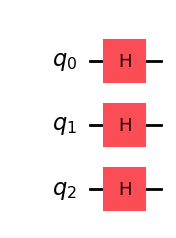

In [2]:
from qiskit import *
import matplotlib.pyplot as plt
import numpy as np  

# Create a Quantum Circuit acting on a quantum register of 5 qubits
qc = QuantumCircuit(5,5)

# Subcircuit for uniform state preparation operator
spo = QuantumCircuit(3,name="state_prep")

# Add a H gate on all qubits except the last one
# This will give the superposition of all the qubits except the last one
for qubit in range(3):
    spo.h(qubit)
qc.x(4)
qc.h(4)
qc.barrier()

# qc.decompose(gates_to_decompose="state_prep").draw('mpl')
spo.draw('mpl')

2. Manually creating the oracle circuit for evaulating the scaled down vertex coloring problem shown below

![Simple Vertex Coloring problem](vertex_coloring_instance.png)

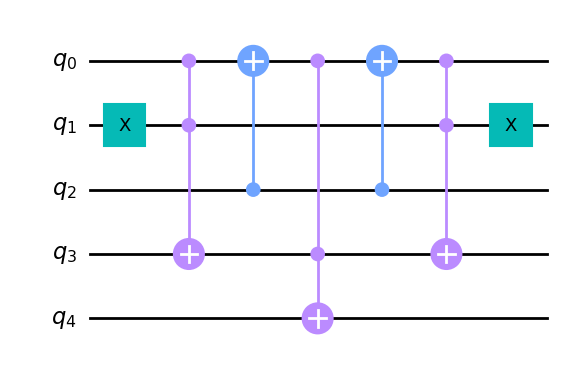

In [3]:

# Create a quantum subcircuit for grover oracle
grover_oracle = QuantumCircuit(5, name="grover_oracle")
grover_oracle.x(1)
grover_oracle.ccx(0,1,3)
grover_oracle.cx(2,0)
grover_oracle.ccx(0,3,4)
grover_oracle.cx(2,0)
grover_oracle.ccx(0,1,3)
grover_oracle.x(1)

grover_oracle.draw('mpl',style='clifford')


3. Defining the diffusion operator

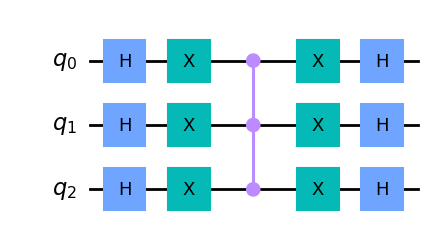

In [4]:
# Create a quantum subcircuit for grover diffusion operator
grover_diffusion = QuantumCircuit(3, name="grover_diffusion")
grover_diffusion.h([0,1,2])
grover_diffusion.x([0,1,2])
grover_diffusion.ccz(0,1,2)
grover_diffusion.x([0,1,2])
grover_diffusion.h([0,1,2])

grover_diffusion.draw('mpl',style='clifford')

4. Connect the whole circuit together together for the first iteration

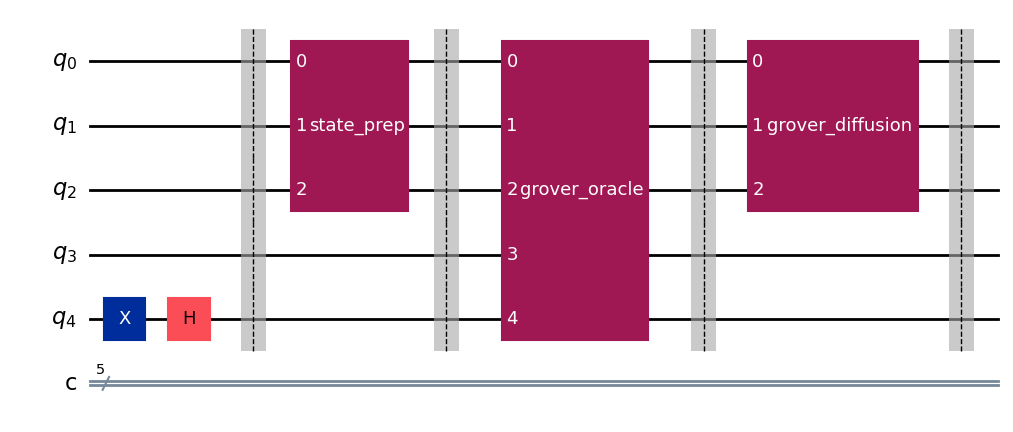

In [5]:
# Combining the subcircuits to form the complete Grover's algorithm
qc.append(spo, [0, 1, 2])
qc.barrier()
qc.append(grover_oracle, [0,1,2,3,4])
qc.barrier()
qc.append(grover_diffusion, [0,1,2])
qc.barrier()

qc.draw('mpl')

5. Add measurements and running the circuit of the AER simulator

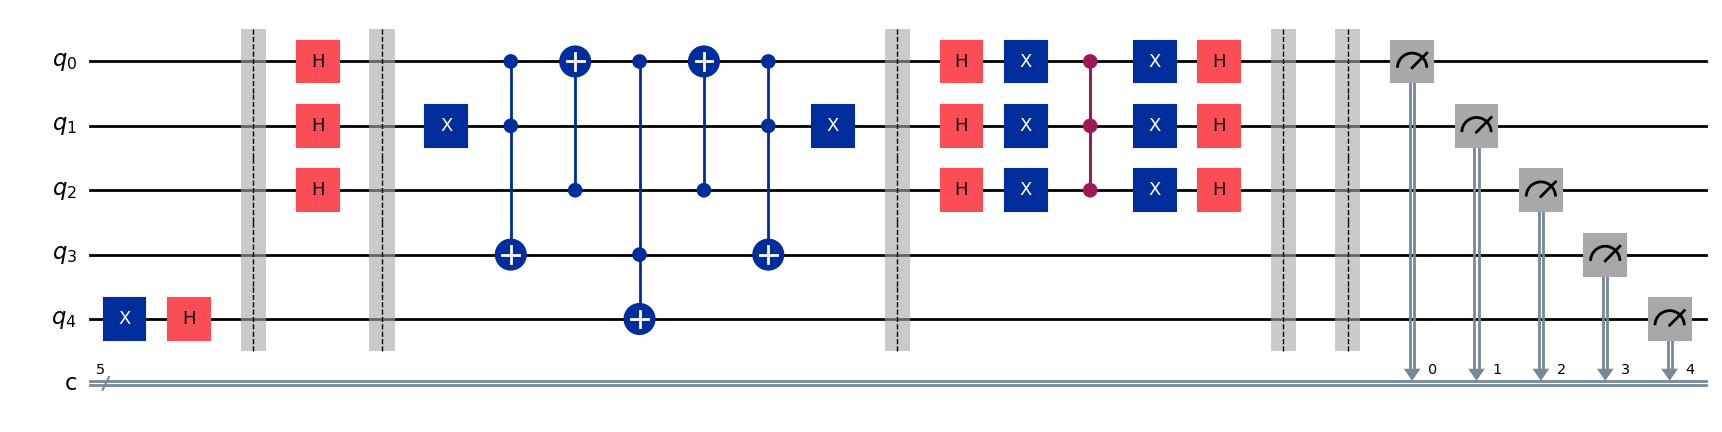

In [6]:

# qc.measure([0, 1, 2], [0, 1, 2]) # Measure the first 3 qubits
qc.measure_all(add_bits=False)
qc_decomposed : QuantumCircuit = qc.decompose(gates_to_decompose=["state_prep", "grover_oracle", "grover_diffusion"])
qc_decomposed.draw('mpl')


{'000': 33, '001': 796, '010': 29, '011': 37, '100': 30, '101': 25, '110': 40, '111': 34}


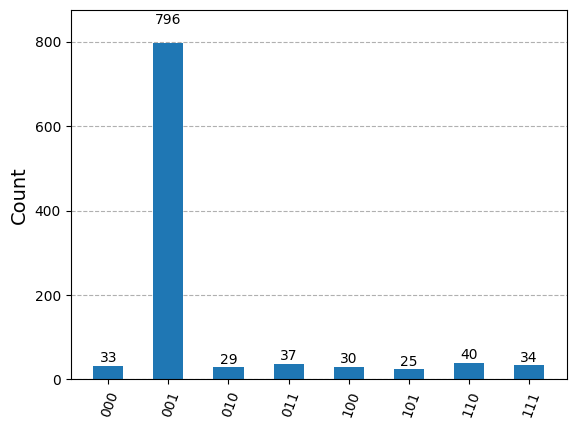

In [7]:
from qiskit_aer import Aer
# import basic plot tools
from qiskit.visualization import plot_histogram

# Creating the backend
qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(qc_decomposed).result()
counts = result.get_counts()

# A function to extract the counts of the useful qubits
def process_counts(counts, num_qubits=3):
    # New dictionary to store our results in.
    new_counts = {f'{i:0{num_qubits}b}': 0 for i in range(2**num_qubits)}

    # Loop through the counts dictionary, adding the value to the 
    # respective key in new_counts based on what state the show_qubit is in
    for count in counts:
        count_idx = (len(count) - num_qubits)
        new_counts[count[count_idx:count_idx+num_qubits]] += counts[count]
    
    return new_counts

# Use the function to process the counts
new_counts = process_counts(counts)
print(new_counts)
plot_histogram(new_counts)

# plot_histogram(counts)

6. Running on a real device

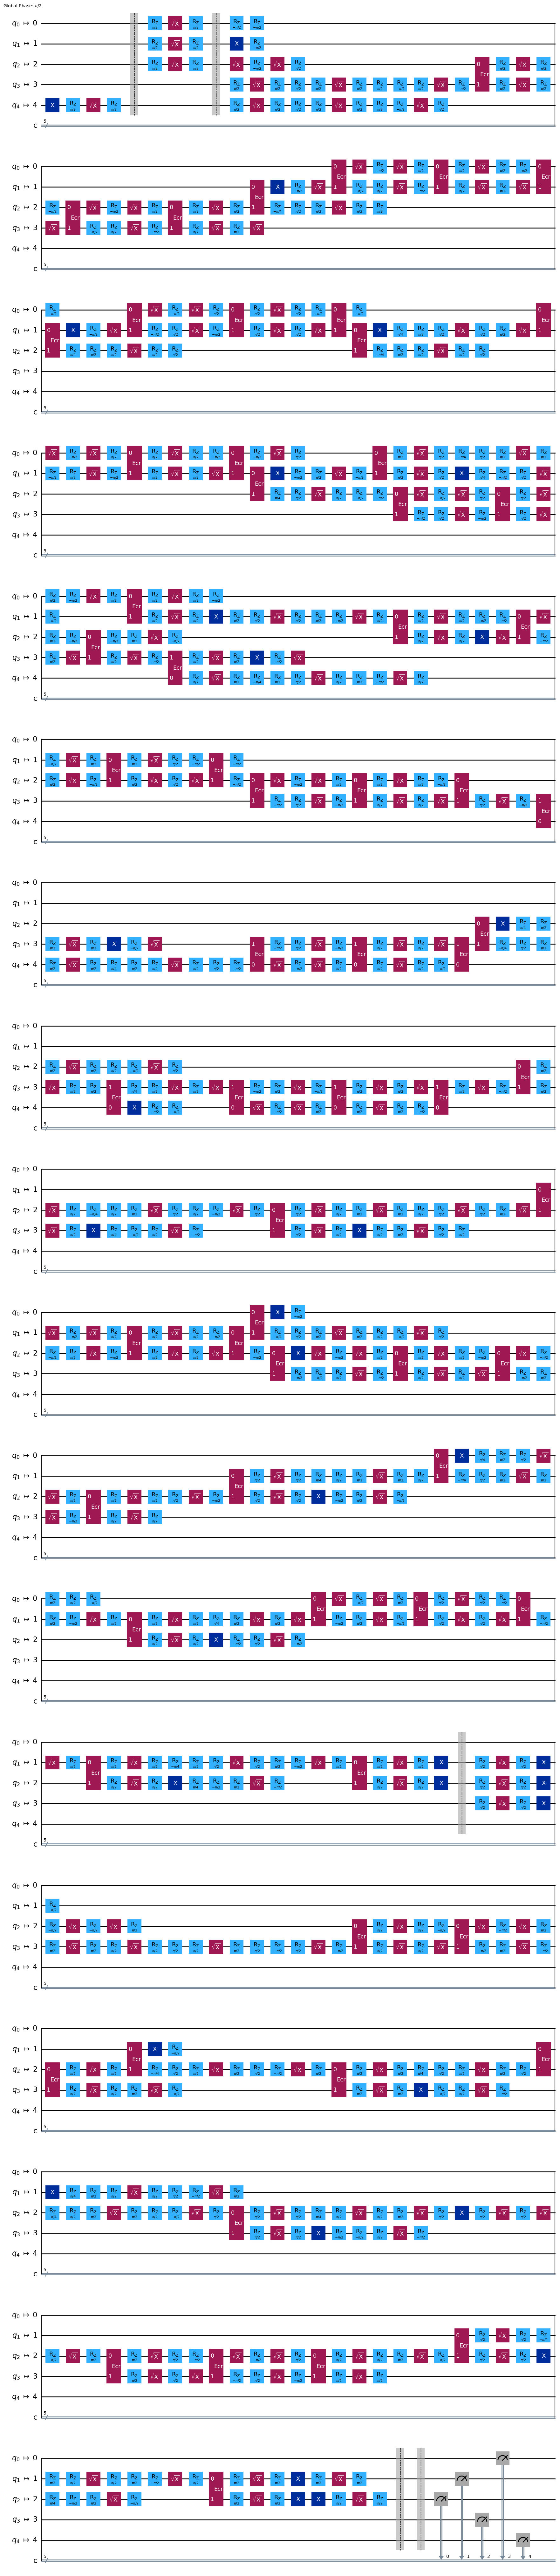

In [8]:

# Run our circuit on the least busy backend. Transpiling before running.
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=0)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")


In [9]:
# Print the transpiled circuit depth 
print(circuit_isa.depth())

440


# Dynamic Decoupling Circuit (JB's code)
This code snippet demonstrates the use of dynamic decoupling to mitigate decoherence in quantum circuits. The `PassManager` is configured with the `ALAPScheduleAnalysis` and `PadDynamicalDecoupling` passes to apply dynamic decoupling sequences to the circuit. The optimized circuits are then transpiled and their depths are printed.

In [10]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicCircuitInstructionDurations

durations = DynamicCircuitInstructionDurations.from_backend(backend=backend)


optimized_pm = generate_preset_pass_manager(target=target, optimization_level=3)
dd_rep = 8
dd_sequence = [XGate()] * dd_rep

optimized_pm.scheduling = PassManager([
    ALAPScheduleAnalysis(durations=durations),
    PadDynamicalDecoupling(
        durations=durations,
        dd_sequences=dd_sequence,
        pulse_alignment=16
    )
])
NUM_TRIAL = 10
transpiled_circuits = []
for i in range(NUM_TRIAL):
    transpiled_circuits.append(optimized_pm.run(qc))


depths = [circuit.depth() for circuit in transpiled_circuits]
print(depths)

[249, 241, 249, 241, 297, 249, 249, 241, 241, 241]


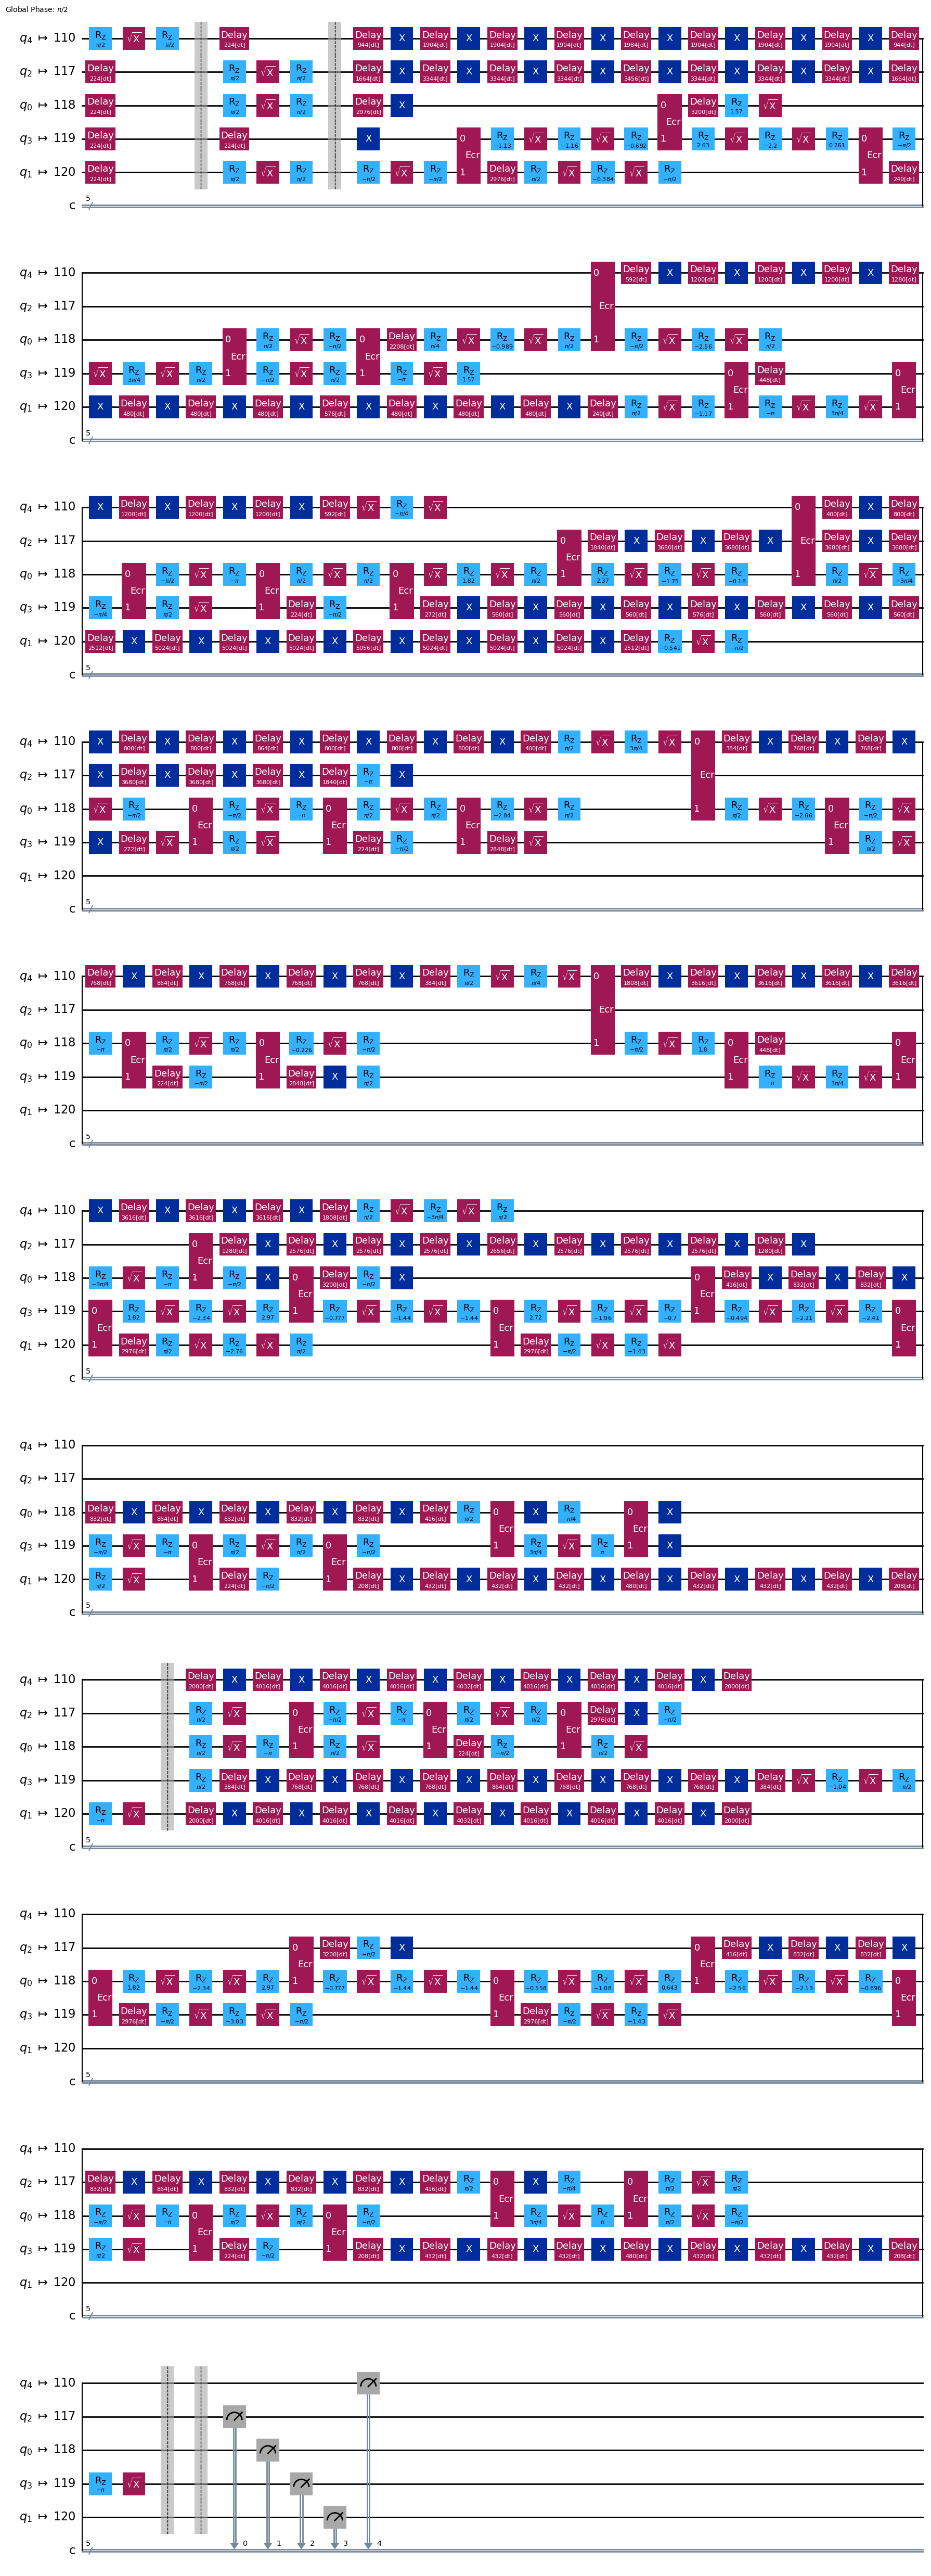

In [11]:
# Draw the circuit
transpiled_circuit = transpiled_circuits[0]
transpiled_circuit.draw('mpl', idle_wires=False,
                        )

In [12]:
# Listing the qubits used in the transpiled circuit
used_qubits = transpiled_circuit.layout.final_index_layout()
used_qubits

[117, 118, 119, 120, 110]

In [13]:
import mthree
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(used_qubits)

[RunningManJob<job_id='cyjg2q2nrmz0008tdt6g', backend_name='ibm_kyiv', executor='NA'>]

In [14]:
# # Running the transpiled circuit using the sampler
# from qiskit_ibm_runtime import Sampler
# sampler = Sampler(mode=backend)
# sampler.options.default_shots = 10_000
# job = sampler.run([transpiled_circuit])

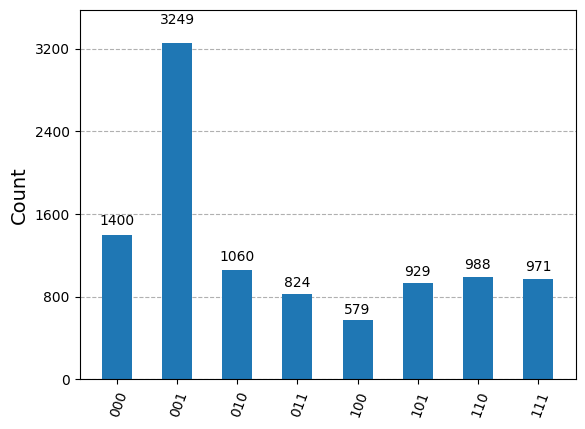

In [15]:
from qiskit.visualization import plot_distribution
# result = sampler.run([transpiled_circuit]).result()
result = service.job('cydx6zv9b62g008jh280').result()
raw_counts = result[0].data.c.get_counts()
plot_histogram(raw_counts)

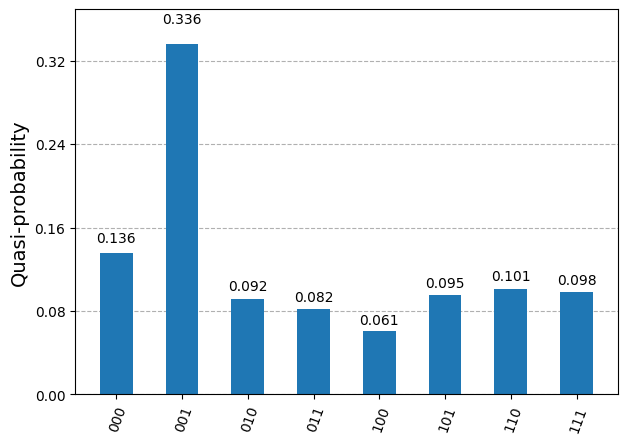

In [16]:
result_2 = service.job('cydx70c9b62g008jh290').result()
raw_counts_2 = result_2[0].data.c.get_counts()
plot_distribution(raw_counts_2)

In [ ]:
quasi = mit.apply_correction(raw_counts_2, [61,60,53])

mitigated_counts = {k: int(v*10_000) for k, v in quasi.items()}

plot_distribution(mitigated_counts)

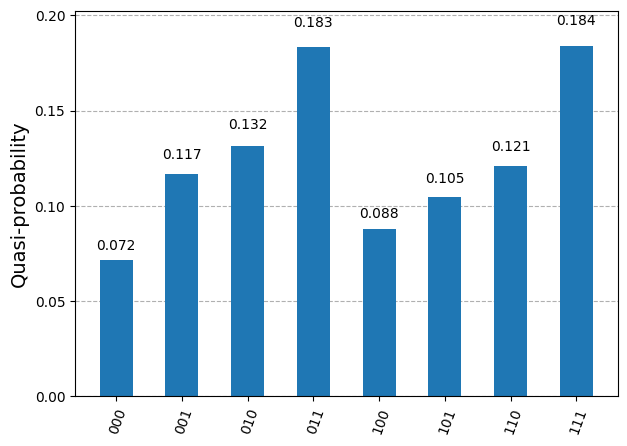

In [128]:
# # With optimization level 3
# from qiskit_ibm_runtime import Sampler
# from qiskit.visualization import plot_distribution
# sampler = Sampler(mode=backend)
# sampler.options.default_shots = 10_000
# result = sampler.run([circuit_isa]).result()
# dist = result[0].data.c.get_counts()
# plot_distribution(dist)


In [1]:
from qiskit.visualization import plot_distribution
job = service.job('cydv20r01rbg008k3kc0')
result = job.result()
dist = result[0].data.c.get_counts()
plot_distribution(dist)

NameError: name 'service' is not defined